
#**Facial non-threatening skin disease detection using Convolution Neural Networks**

**Skin Disease Image Classification having 5 class labels (Acne,Melasma,Rosacea,Hives,Eczema)**



#Importing Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf
from keras.layers import Dense
import keras

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Declaring Class Types and Data Folder

In [0]:
skindisease_types=['Acne','Melasma','Rosacea','Hives','Eczema']
data_dir = "/content/drive/My Drive/DL-Project/Dataset/"
train_dir = os.path.join(data_dir)

#Creating Training Dataset

In [0]:
train_data = []
for disease_id, sp in enumerate(skindisease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), disease_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseId','Disease Type'])
train.tail()

,File,DiseaseId,Disease Type
1457,Eczema/1.jpg,4,Eczema
1458,Eczema/28WarutChinsaiC2A9Shutterstock.com2920-...,4,Eczema
1459,Eczema/1497-psoriasis_vs_eczema-642x361-eczema...,4,Eczema
1460,Eczema/12_CATERS_MIRACLE_ECZEMA_CREAM_01-506x1...,4,Eczema
1461,Eczema/0_PAY-MIRACLE-ECZEMA-CREAM.jpg,4,Eczema


#Randomizing Dataset

In [0]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseId,Disease Type
0,Rosacea/images11.jpg,2,Rosacea
1,Hives/images202.jpg,3,Hives
2,Melasma/images278.jpg,1,Melasma
3,Melasma/images116.jpg,1,Melasma
4,Hives/images697.jpg,3,Hives


#Histogram of Skin Disease Types

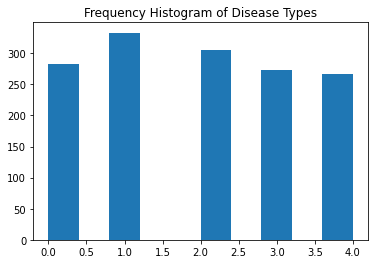

<Figure size 864x864 with 0 Axes>

In [0]:
# Plot a histogram
plt.hist(train['DiseaseId'])
plt.title('Frequency Histogram of Disease Types')
plt.figure(figsize=(12, 12))
plt.show()

#Display Images from a Skin Disease Type

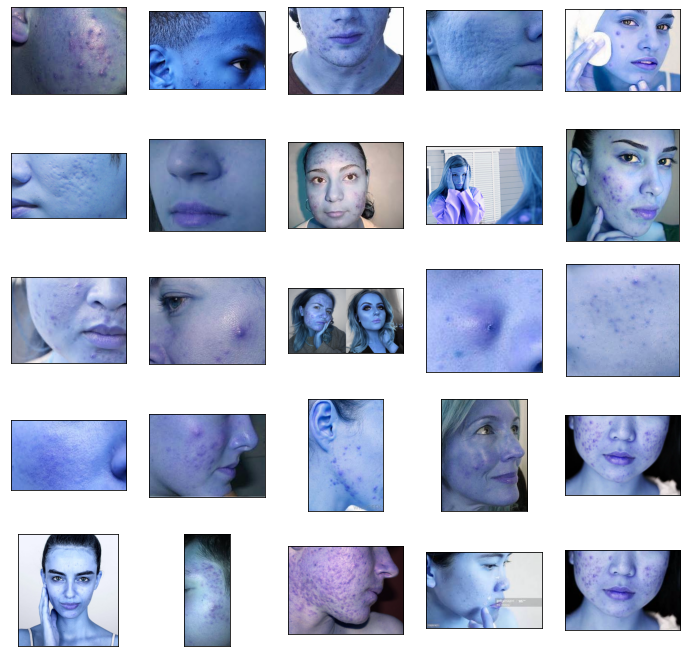

In [0]:
def plot_defects(skindisease_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    flower_files = train['File'][train['Disease Type'] == skindisease_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, flower_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Acne', 5, 5)

#Resizing and Image Reading

In [0]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

#Creating X_train Dataset

In [0]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255
print('Train Shape: {}'.format(X_Train.shape))

1462it [00:09, 154.67it/s]

Train Shape: (1462, 64, 64, 3)


#Creating Y_train Dataset

In [0]:
Y_train = train['DiseaseId'].values
Y_train = to_categorical(Y_train, num_classes=5)

#Creating Train and Validation Dataset

In [0]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)
print(len(X_train))
print(len(Y_train))
print(len(X_val))
print(len(Y_val))

1169
1169
293
293


#Showing Skin Disease From Different Types

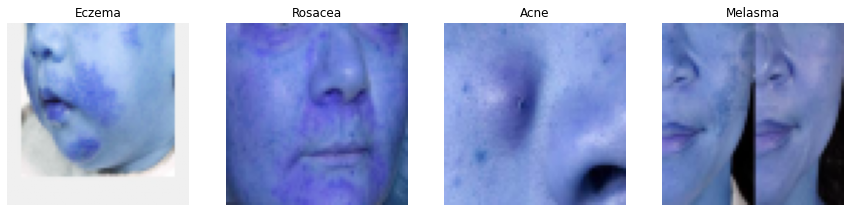

In [0]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(skindisease_types[np.argmax(Y_train[i])])

#MODEL 1 : CNN Model from Scratch

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#Data Augmentation and Model Fitting
### This is to avoid overfitting as this is a small dataset

In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,MaxPooling2D

image_dir = "/content/drive/My Drive/DL-Project/Dataset/"
data_generator = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=30, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest"
                                   )

train_generator = data_generator.flow_from_directory(
        image_dir,
        subset="training",
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

#print(train_generator)
validation_generator = data_generator.flow_from_directory(
        image_dir,
        subset="validation",
        target_size=(64,64),
        class_mode='categorical')

Found 1172 images belonging to 5 classes.
Found 290 images belonging to 5 classes.


In [0]:
history = model.fit_generator(
          train_generator,
          steps_per_epoch=25,
          epochs=50,
          validation_data=validation_generator,
          validation_steps=50)

Epoch 1/50
25/25 [==============================] - 23s 913ms/step - loss: 1.6139 - acc: 0.2438 - val_loss: 1.4651 - val_acc: 0.2276
Epoch 2/50
25/25 [==============================] - 19s 758ms/step - loss: 1.5999 - acc: 0.2706 - val_loss: 1.7395 - val_acc: 0.2021
Epoch 3/50
25/25 [==============================] - 19s 758ms/step - loss: 1.5859 - acc: 0.2837 - val_loss: 1.5156 - val_acc: 0.2821
Epoch 4/50
25/25 [==============================] - 19s 766ms/step - loss: 1.5584 - acc: 0.3058 - val_loss: 1.1508 - val_acc: 0.2359
Epoch 5/50
25/25 [==============================] - 19s 767ms/step - loss: 1.5434 - acc: 0.3299 - val_loss: 1.1144 - val_acc: 0.2745
Epoch 6/50
25/25 [==============================] - 19s 758ms/step - loss: 1.5119 - acc: 0.3375 - val_loss: 1.3944 - val_acc: 0.3055
Epoch 7/50
25/25 [==============================] - 19s 759ms/step - loss: 1.4967 - acc: 0.3528 - val_loss: 1.7052 - val_acc: 0.2931
Epoch 8/50
25/25 [==============================] - 19s 767ms/step - 

#Highest Accuracy

In [0]:
#Model from scratch using CNN 
print(max(history.history["acc"]))
print(max(history.history["val_acc"]))

0.49365482
0.44413793087005615


#Accuracy and Loss Curve


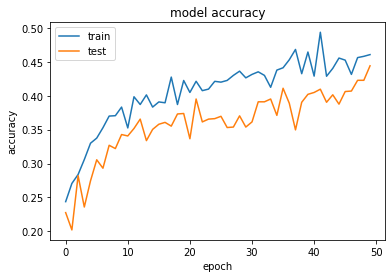

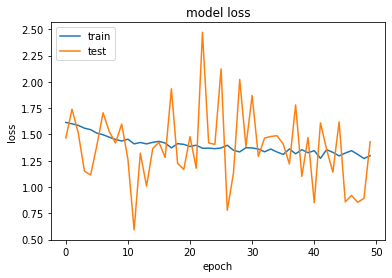

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Baseline Accuracy of the Model

In [0]:
a=333 #max
b=283+333+306+273+267
print("Baseline_Accuracy=",a/b*100)

Baseline_Accuracy= 22.77701778385773


#Building Transfer Learning Models

#MODEL 2 : Building Mobilenetv2 Model

In [0]:
#Mobilenet
import tensorflow as tf
from keras.layers import Dense
from keras import Sequential
from keras.applications import mobilenet


my_new_model = Sequential()
my_new_model.add(mobilenet.MobileNet(include_top=False, pooling='avg', weights='imagenet'))
my_new_model.add(Dense(5, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

my_new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
histt=my_new_model.fit(X_train, Y_train, batch_size= 64, epochs=10, validation_split=0.1)




/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 1052 samples, validate on 117 samples
Epoch 1/10
1052/1052 [==============================] - 1s 1ms/step - loss: 2.6205 - accuracy: 0.2072 - val_loss: 2.2849 - val_accuracy: 0.2479
Epoch 2/10
1052/1052 [==============================] - 0s 236us/step - loss: 2.0567 - accuracy: 0.3146 - val_loss: 2.1845 - val_accuracy: 0.2650
Epoch 3/10
1052/1052 [==============================] - 0s 236us/step - loss: 1.7821 - accuracy: 0.3669 - val_loss: 2.1169 - val_accuracy: 0.3077
Epoch 4/10
1052/1052 [==============================] - 0s 236us/step - loss: 1.6149 - accuracy: 0.4087 - val_loss: 2.0590 - val_accuracy: 0.3077
Epoch 5/10
1052/1052 [==============================] - 0s 235us/step - loss: 1.4244 - accuracy: 0.4705 - val_loss: 1.9527 - val_accuracy: 0.3248
Epoch 6/10
1052/1052 [==============================] - 0s 240us/step - loss: 1.3239 - accuracy: 0.5019 - val_loss: 1.8893 - val_accuracy: 0.3333
Epoch 7/10
1052/1052 [==============================] - 0s 232us/step - loss: 1

#Highest Accuracy

In [0]:
print(max(histt.history["accuracy"]))
print(max(histt.history["val_accuracy"]))

0.6207224
0.34188035130500793


#Accuracy and Loss Curve

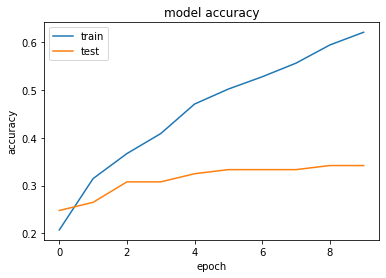

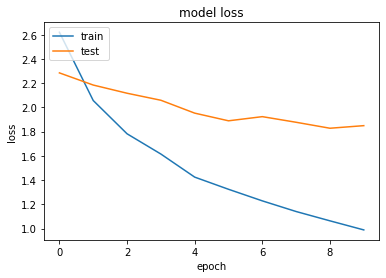

In [0]:
plt.plot(histt.history['accuracy'])
plt.plot(histt.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(histt.history['loss'])
plt.plot(histt.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#MODEL3 : Building DenseNet121 Model

In [0]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(5,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

#Data Augmentation and Model Fitting

In [0]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_25  (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               2624

#Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

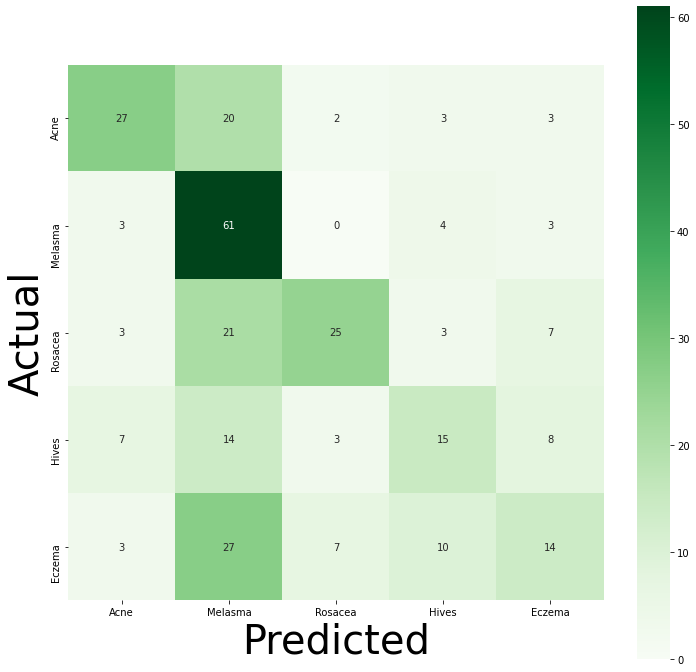

In [0]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=skindisease_types, yticklabels=skindisease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

#Highest Accuracy

In [0]:
print(max(hist.history["accuracy"]))
print(max(hist.history["val_accuracy"]))

0.5902778
0.5904436707496643


###Densenet121 Model is performing better than the other two models

#Accuracy and Loss Curve

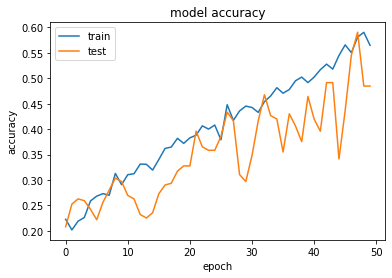

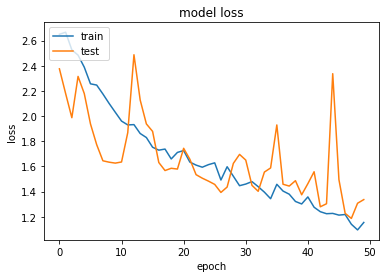

In [0]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Testing Prediction with the best performing Model(DenseNet121)

###Prediction from the validation dataset->correctly classified

[0.01192113 0.00131099 0.07235911 0.8761666  0.03824217]


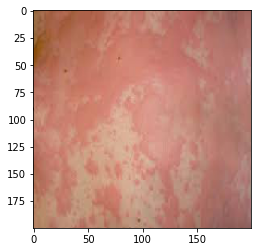

Prediction: Hives


In [0]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('50.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('50.jpg', grayscale=False, target_size=(200, 200))
skindisease_types=['Acne','Melasma','Rosacea','Hives','Eczema']

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


x = np.array(x, 'float32')


#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skindisease_types[ind])

[0.04694272 0.06829087 0.6758089  0.08564199 0.12331551]


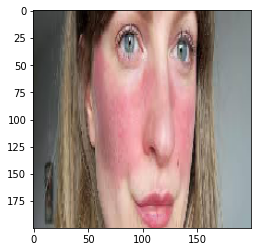

Prediction: Rosacea


In [0]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('67.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('67.jpg', grayscale=False, target_size=(200, 200))
skindisease_types=['Acne','Melasma','Rosacea','Hives','Eczema']

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


x = np.array(x, 'float32')


#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skindisease_types[ind])

### Hand images taken from google search (these images were not in training or validation set)-> correctly classified


[0.06522597 0.04232613 0.18725798 0.47540334 0.22978653]


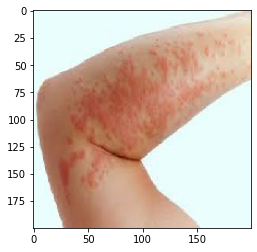

Prediction: Hives


In [0]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('52.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('52.jpg', grayscale=False, target_size=(200, 200))
skindisease_types=['Acne','Melasma','Rosacea','Hives','Eczema']

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


x = np.array(x, 'float32')


#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skindisease_types[ind])

[0.07292391 0.10621437 0.21599557 0.34715167 0.2577145 ]


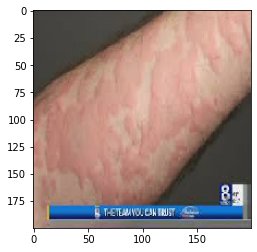

Prediction: Hives


In [0]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('58.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('58.jpg', grayscale=False, target_size=(200, 200))
skindisease_types=['Acne','Melasma','Rosacea','Hives','Eczema']

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


x = np.array(x, 'float32')


#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skindisease_types[ind])

###Prediction from the validation test->incorrectly classified due to just 62% Accuracy

[0.27313393 0.13434471 0.14084065 0.23268978 0.21899092]


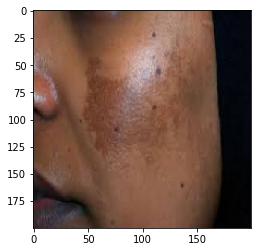

Prediction: Acne


In [0]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('25.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('25.jpg', grayscale=False, target_size=(200, 200))
skindisease_types=['Acne','Melasma','Rosacea','Hives','Eczema']

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


x = np.array(x, 'float32')
#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skindisease_types[ind])

[0.01192113 0.00131099 0.07235911 0.8761666  0.03824217]


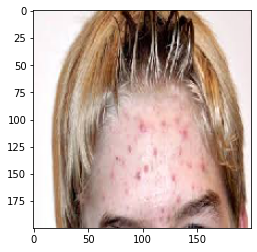

Prediction: Hives


In [0]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('50.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('49.jpg', grayscale=False, target_size=(200, 200))
skindisease_types=['Acne','Melasma','Rosacea','Hives','Eczema']

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


x = np.array(x, 'float32')


#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skindisease_types[ind])